In [1]:
import pandas as pd
import numpy as np

In [2]:
targetDF = pd.read_csv('./Cleaned_data/Cleaned_Data.csv')
targetDF['local'] = pd.to_datetime(targetDF['local'])
targetDF = targetDF.set_index('local')


# Pm25 value prediction SARIMA

Checking stationarity for SARIMA and ARIMA compatibility

In [27]:
from  statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

check_stationarity(targetDF['value'])

ADF Statistic: -7.893641419957941
p-value: 4.369066197084931e-12
Stationary


### Test train spllit

In [3]:
split_date = pd.to_datetime('2021-3-5 23:00:00+05:45')  
train = targetDF[targetDF.index <= split_date]
test  = targetDF[targetDF.index > split_date]



### STL decompostition
First we separate trend, seasonality and residual of data using STL decomposition. Then predict both future trend and residual and combining both with seasonality to get final predictions 

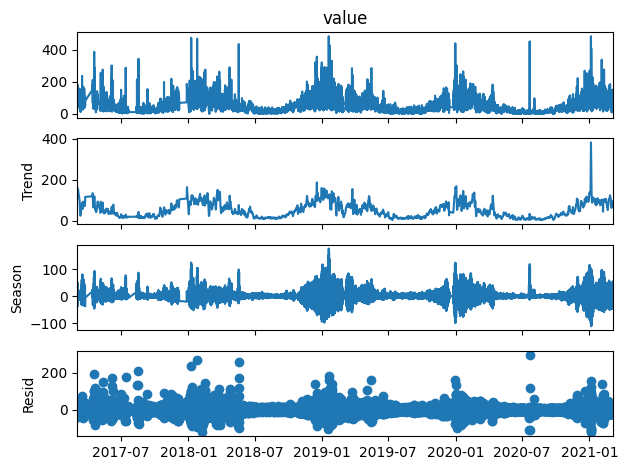

In [4]:

from statsmodels.tsa.seasonal import STL
stl = STL(train['value'],period=24)
res = stl.fit()
fig = res.plot()


#### Arima optimal parameter
Using auto arima from Satatsforecast to find optimal ARIMA parameters for both Residual and trend

In [60]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
residual = res.resid
season_length = 24
horizon = len(test)
df = pd.DataFrame({
    'unique_id': 'residuals',  
    'ds': res.resid.index,
    'y': res.resid.values
})
models = [AutoARIMA(season_length=season_length)]
sf = StatsForecast(models=models, freq='h')
sf.fit(df=df)

StatsForecast(models=[AutoARIMA])

In [62]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(2,0,1)(2,0,0)[24] with zero mean    '

In [61]:
trend = res.trend
season_length = 24
horizon = len(test)
df = pd.DataFrame({
    'unique_id': 'trend',  
    'ds': res.trend.index,
    'y': res.trend.values
})
models = [AutoARIMA(season_length=season_length)]
sf2 = StatsForecast(models=models, freq='h')
sf2.fit(df=df)

StatsForecast(models=[AutoARIMA])

In [63]:
arima_string(sf2.fitted_[0,0].model_)

'ARIMA(0,1,5)(1,0,2)[24] with drift        '

Applying SARIMAX model on residual

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
p,d,q = 2,0,1
P,D,Q,s = 2,0,0,24
residual = res.resid
residual = residual.asfreq('h')
residual.index = pd.DatetimeIndex(residual.index,freq='h')
model = SARIMAX(residual, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False) 
print(model_fit.summary())
model_fit.save('sarimax_model_resid.pkl')

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               resid   No. Observations:                35131
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 24)   Log Likelihood             -122690.569
Date:                             Sat, 25 Oct 2025   AIC                         245393.138
Time:                                     08:43:50   BIC                         245443.939
Sample:                                 03-03-2017   HQIC                        245409.317
                                      - 03-05-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5858      0.001   1185.006      0.000       1.583       1.588
ar.L2         -0.6575      

Applying SARIMAX model on trend

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
p,d,q = 0,1,5
P,D,Q,s = 1,0,2,24
trend = res.trend
trend = trend.asfreq('h')
trend.index = pd.DatetimeIndex(trend.index,freq='h')
model2 = SARIMAX(trend, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit2 = model2.fit(disp=False) 
print(model_fit2.summary())
model_fit2.save('sarimax_model_trend.pkl')

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                   trend   No. Observations:                35131
Model:             SARIMAX(0, 1, 5)x(1, 0, [1, 2], 24)   Log Likelihood               20920.490
Date:                                 Sat, 25 Oct 2025   AIC                         -41822.981
Time:                                         09:56:33   BIC                         -41746.780
Sample:                                     03-03-2017   HQIC                        -41798.713
                                          - 03-05-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          2.4171      0.002   1476.832      0.000       2.414       2

In [8]:
import statsmodels.api as sm 
model_fit = sm.load('sarimax_model_resid.pkl')

In [9]:
forecast_resid = model_fit.forecast(steps = len(test))
forecast_trend = model_fit2.forecast(steps= len(test))
future_seasonal = res.seasonal[-166:]
final_forecast = forecast_resid + forecast_trend + future_seasonal.values

# Model evaluation

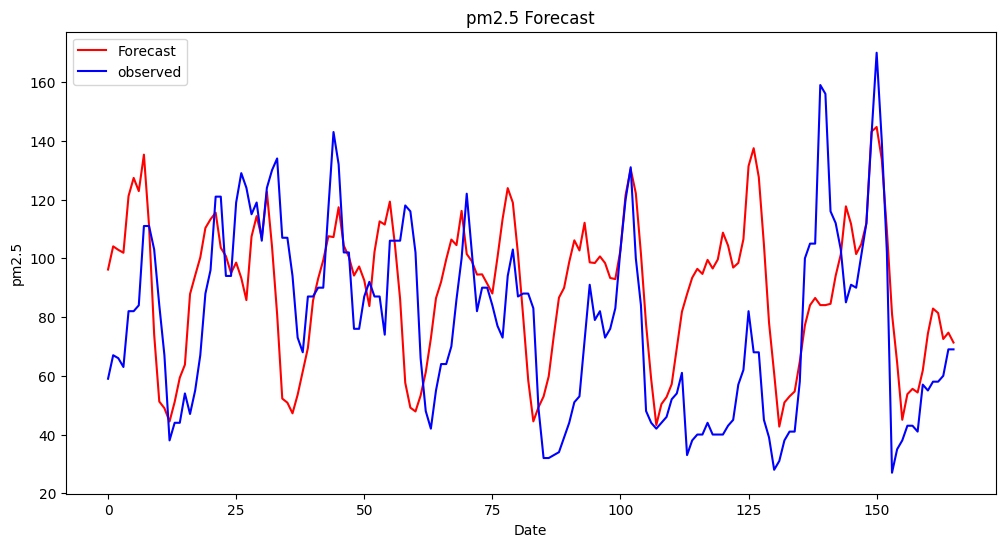

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(final_forecast.values, label='Forecast', color='red')
plt.plot(test['value'].values, label='observed', color='blue')
plt.title("pm2.5 Forecast")
plt.xlabel("Date")
plt.ylabel("pm2.5")
plt.legend()
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['value'].values, final_forecast.values)
mae

24.900484305672663